# Dependencies

In [43]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, save, load
from termcolor import colored
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Get data 

In [44]:
train = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
dataset = DataLoader(train, 32)
#1,28,28 - classes 0-9

# Image Classifier Neural Network

In [45]:
class ImageClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(64, 128, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(128, 128, (3,3)), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(128*(28-8)*(28-8), 10)  
        )

    def forward(self, x): 
        return self.model(x)


# Instance of the neural network, loss, optimizer 

In [46]:
clf = ImageClassifier().to('cuda')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() 

# Training flow 

In [48]:
for epoch in range(10): # train for 10 epochs
    for batch in dataset: 
        X,y = batch 
        X, y = X.to('cuda'), y.to('cuda') 
        yhat = clf(X) 
        loss = loss_fn(yhat, y) 

        # Apply backprop 
        opt.zero_grad()
        loss.backward() 
        opt.step() 

    print(f"Epoch: {epoch} loss is {loss.item()}")
    
with open('model_state.pt', 'wb') as f: 
    save(clf.state_dict(), f) 

Epoch: 0 loss is 0.0025814047548919916
Epoch: 1 loss is 0.000368418957805261
Epoch: 2 loss is 0.00023802903888281435
Epoch: 3 loss is 2.716273593250662e-05
Epoch: 4 loss is 5.252525625110138e-06
Epoch: 5 loss is 1.0243702490697615e-05
Epoch: 6 loss is 3.9115499816944066e-07
Epoch: 7 loss is 1.031889155456156e-06
Epoch: 8 loss is 2.5051620468730107e-05
Epoch: 9 loss is 3.874289404848241e-07


# Testing

In [49]:
with open('model_state.pt', 'rb') as f: 
    clf.load_state_dict(load(f)) 

img1 = Image.open('img_1.jpg') 
img1_tensor = ToTensor()(img1).unsqueeze(0).to('cuda')
print("For Img1: "+ colored(torch.argmax(clf(img1_tensor)), 'green', attrs=['bold']))

img2 = Image.open('img_2.jpg') 
img2_tensor = ToTensor()(img2).unsqueeze(0).to('cuda')
print("For Img2: "+ colored(torch.argmax(clf(img2_tensor)), 'green', attrs=['bold']))

img3 = Image.open('img_3.jpg') 
img3_tensor = ToTensor()(img3).unsqueeze(0).to('cuda')
print("For Img3: "+ colored(torch.argmax(clf(img3_tensor)), 'green', attrs=['bold']))

For Img1: tensor(2, device='cuda:0')
For Img2: tensor(0, device='cuda:0')
For Img3: tensor(9, device='cuda:0')


           Image


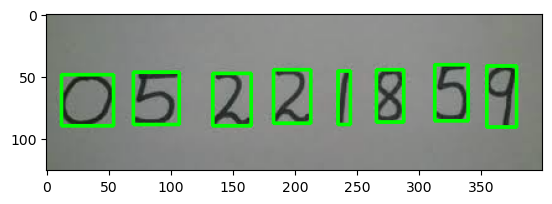

In [63]:
image = cv2.imread('img.jpeg')
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
preprocessed_digits = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    
    # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    
    # Cropping out the digit from the image corresponding to the current contours in the for loop
    digit = thresh[y:y+h, x:x+w]
    
    # Resizing that digit to (18, 18)
    resized_digit = cv2.resize(digit, (18,18))
    
    # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
    padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
    
    # Adding the preprocessed digit to the list of preprocessed digits
    preprocessed_digits.append(padded_digit)
print("           Image")
plt.imshow(image, cmap="gray")
plt.show()
    
inp = np.array(preprocessed_digits)


Prediction


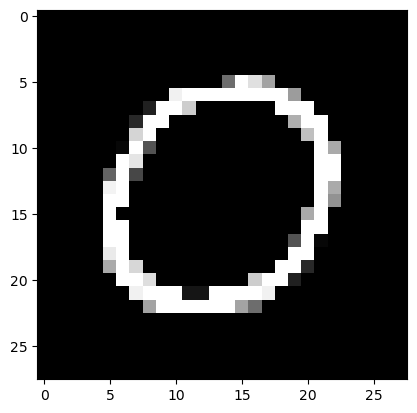

Output: tensor(0, device='cuda:0')

Prediction


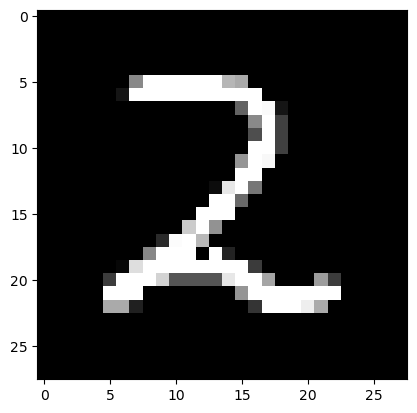

Output: tensor(2, device='cuda:0')

Prediction


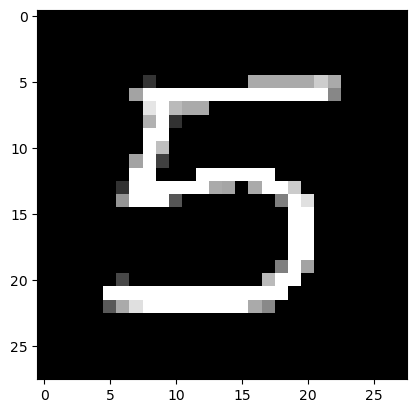

Output: tensor(5, device='cuda:0')

Prediction


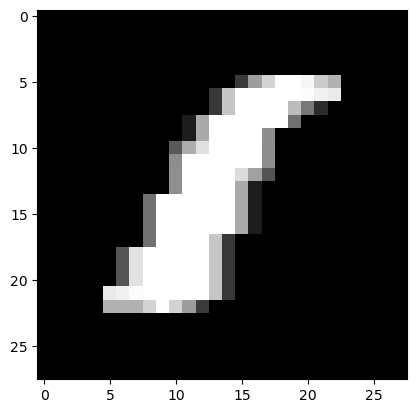

Output: tensor(8, device='cuda:0')

Prediction


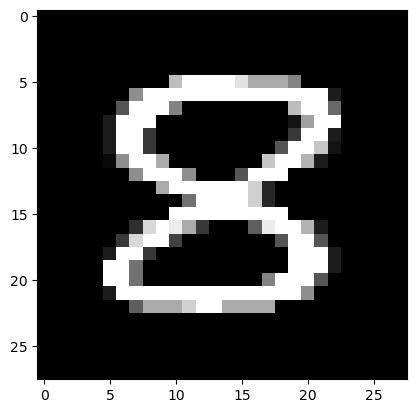

Output: tensor(8, device='cuda:0')

Prediction


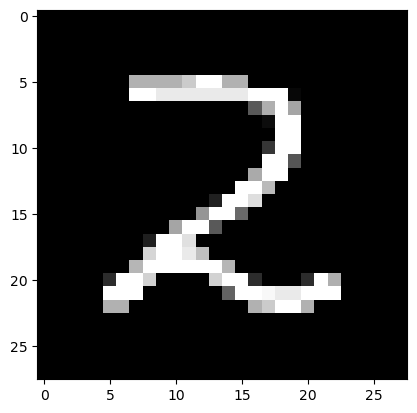

Output: tensor(2, device='cuda:0')

Prediction


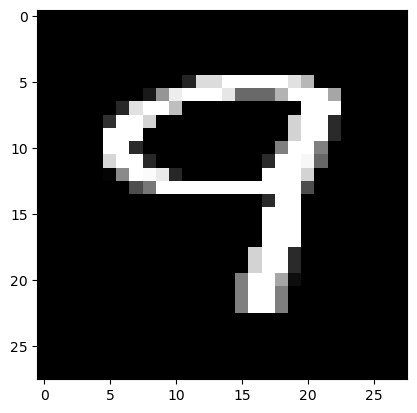

Output: tensor(9, device='cuda:0')

Prediction


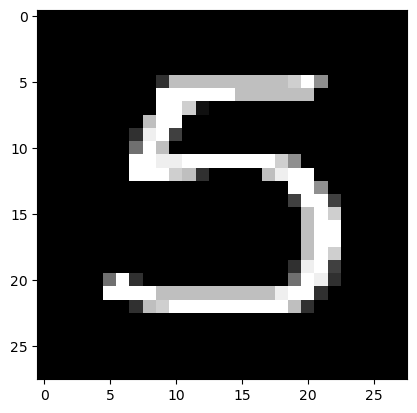

Output: tensor(5, device='cuda:0')


In [64]:
for digit in preprocessed_digits:
    prediction = ToTensor()(digit).unsqueeze(0).to('cuda')
    print(colored("\nPrediction", 'green', attrs=['bold']))
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("Output: " + colored(torch.argmax(clf(prediction)), 'green', attrs=['bold']))